In [1]:
devtools::install_github("kbroman/GNapi")


✔  checking for file ‘/tmp/RtmpCTaO31/remotes35ba726d1f83/kbroman-GNapi-2eafaf6/DESCRIPTION’
─  preparing ‘GNapi’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Removed empty directory ‘GNapi/docs’
─  building ‘GNapi_0.2-1.tar.gz’
   


Installing package into ‘/home/kbroman/Rlibs’
(as ‘lib’ is unspecified)


In [2]:
library(GNapi)

In [3]:
phe <- get_pheno("BXD", "10015")

Warning message in get_pheno("BXD", "10015"):
“sample_name values are not distinct”

In [4]:
head(phe)

data_id,sample_name,sample_name_2,se,value
<int>,<chr>,<chr>,<dbl>,<dbl>
8967057,BXD1,BXD1,0.17,4.81
8967057,BXD1,BXD1,0.17,4.81
8967057,BXD11,BXD11,0.25,8.39
8967057,BXD11,BXD11,0.25,8.39
8967057,BXD12,BXD12,0.26,4.71
8967057,BXD12,BXD12,0.26,4.71


In [6]:
(pheno <- tapply(phe$value, phe$sample_name, median))

BXD1    BXD11    BXD12    BXD13    BXD14    BXD15    BXD16    BXD18    BXD19     BXD2    BXD21    BXD22 
    4.81     8.39     4.71     4.43     4.83     8.33     9.72     9.64    10.51     8.41     4.20     5.14 
   BXD24    BXD25    BXD27    BXD28    BXD29    BXD30    BXD31    BXD32     BXD5     BXD6     BXD8     BXD9 
    5.02     4.63     9.03     9.72     9.52     4.92     4.84     3.91     4.61     8.31     5.11     4.70 
C57BL/6J   DBA/2J 
   10.12     4.61

In [7]:
install.packages("qtl2", repos="http://rqtl.org/qtl2cran")

Installing package into ‘/home/kbroman/Rlibs’
(as ‘lib’ is unspecified)


In [8]:
library(qtl2)

In [13]:
bxd_file <- "https://raw.githubusercontent.com/rqtl/qtl2data/master/BXD/bxd.zip"

In [14]:
bxd <- read_cross2(bxd_file)

Warning message in recode_geno(sheet, genotypes):
“117497 genotypes treated as missing: "H"”

In [16]:
gmap <- insert_pseudomarkers(bxd$gmap, step=0.2, stepwidth="max")

In [17]:
pmap <- interp_map(gmap, bxd$gmap, bxd$pmap)

In [18]:
pr <- calc_genoprob(bxd, gmap, error_prob=0.002, map_function="c-f")

In [19]:
k <- calc_kinship(pr, "loco")

In [20]:
out <- scan1(pr, pheno, k)

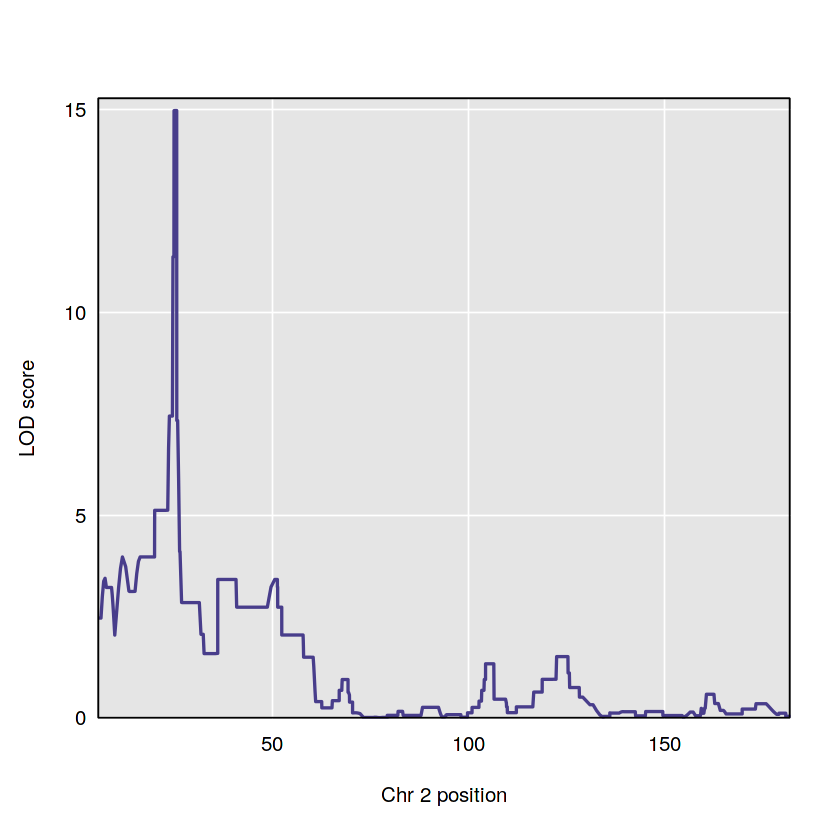

In [22]:
plot(out, pmap, chr=2)

In [23]:
mx <- max(out, pmap)

In [26]:
g_imp <- maxmarg(pr, pmap, chr="2", pos=mx$pos, return_char=TRUE)

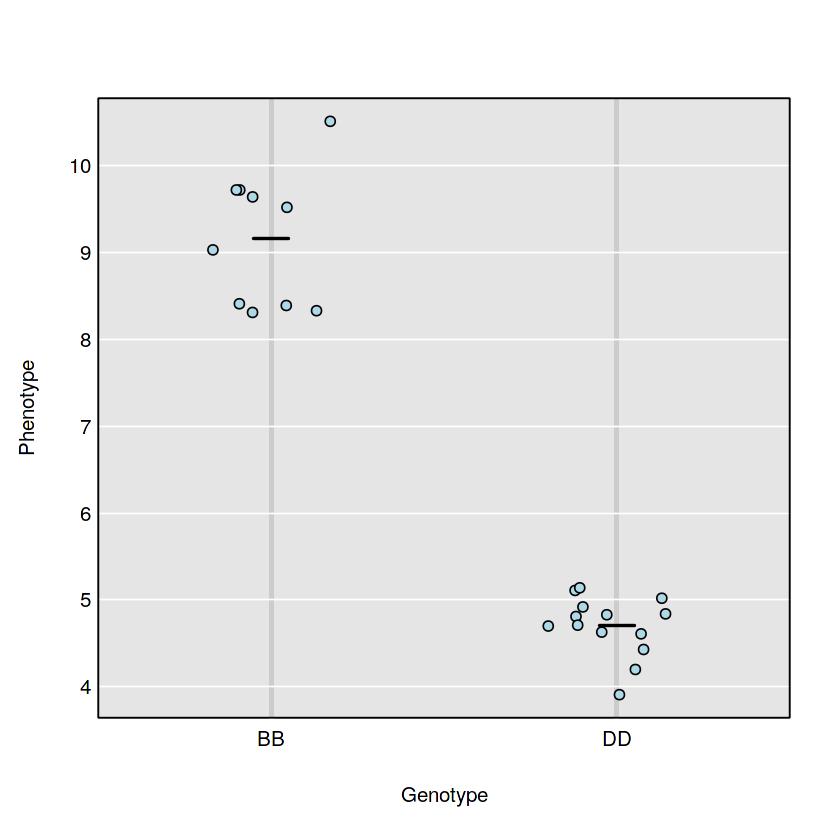

In [27]:
plot_pxg(g_imp, pheno)